<a href="https://colab.research.google.com/github/lookingglasslab/VisualFeatureSearch/blob/main/notebooks/Interactive_Visual_Feature_Search_No_Cache_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Visual Feature Search
## Demo without caching
This colab notebook implements our interactive visual feature search, which allows a user to highlight a free-form region in an image and do a "reverse image search" in CNN intermediate features for similar regions in a dataset.

In this notebook, we do not use an activation cache; thus, we compute and search through VGG16 activations for the first 1k images in Imagenet's validation set in real time.

For fastest results, enable colab's GPU runtime. With a GPU, the search should take 30-60 seconds.

For source code, see our [Github repo](https://github.com/lookingglasslab/VisualFeatureSearch).

## Download ImageNet (**Action Required**)

We use a subset of the ImageNet validation set as our searchable database for visual feature search. To get the dataset:
1. Go to image-net.org and login or signup for access.
2. Go to the following URL: https://image-net.org/challenges/LSVRC/2012/2012-downloads.php
3. Copy the URL for downloading all validation images (with file size of 6.3Gb), and paste the URL below.
4. Run the script below to download the validation set in Colab.

In [ ]:
!wget [ImageNet_val_URL] # TODO: replace me
!mkdir ImageNet-All
!tar -xf ILSVRC2012_img_val.tar -C ImageNet-All

# take ~1,000 images from the val set for our small-scale demo
!mkdir ImageNet
!mv ImageNet-All/ILSVRC2012_val_00000*.JPEG ImageNet/

## Other downloads and Python imports

In [ ]:
!git clone https://github.com/lookingglasslab/VisualFeatureSearch
%pip install --upgrade gdown
%pip install zarr

In [ ]:
import sys
import numpy as np
import requests
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

sys.path.append('./VisualFeatureSearch')
from vissearch import widgets, util, data
from vissearch.searchtool import LiveSearchTool, get_crop_rect

## Set up model and search tool
Search for similar regions in activations after VGG16 conv3 and conv5 blocks (post-pooling).

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  raise Exception('No GPU available')

# slice VGG to get intermediate features
vggmodel = torchvision.models.vgg16(pretrained=True).eval()
vggmodel = vggmodel.eval().to(device)
model_late = vggmodel.features[:]
model_early = vggmodel.features[:17]
# summary(model_late, (3, 224, 224)) # optionally print VGG layer info

LATE_FEATURE_SIZE = 7 # row/column length for the layer of interest
EARLY_FEATURE_SIZE = 28

imagenet_dataset = data.SimpleDataset('ImageNet', return_idxs=False)

# set up the actual search tools
late_search_tool = LiveSearchTool(model_late, device, imagenet_dataset, batch_size=64)
early_search_tool = LiveSearchTool(model_early, device, imagenet_dataset, batch_size=64)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Set up region selection UI

**Instructions:** In the region selection UI below, select a query image. Then, to highlight a region, click on the image, holding down the mouse press, and drag your cursor to highlight a region.

In [ ]:
# download ten query images to use
query_img_ids = ["004", "530", "495", "211", "652", "021", "686", "016", "713", "198"]

def load_img(idx: str):
  url = "https://vissearch.blob.core.windows.net/query-imgs/ILSVRC2012_test_00000" + idx + ".JPEG"
  img = Image.open(requests.get(url, stream=True).raw)
  return img

query_vis_transform = transforms.Compose([
    transforms.CenterCrop((256,256)),
    transforms.Resize((224,224))
])

query_model_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

query_imgs = [load_img(id) for id in query_img_ids]
query_imgs = [query_vis_transform(img) for img in query_imgs]
# convert images to Data URLs so we can pass them into the HTML widget
query_img_urls = [util.image_to_durl(img) for img in query_imgs]

highlight_data = None
highlight_index = None
def highlight_callback(data):
    global highlight_data, highlight_index
    highlight_data = data[0]
    highlight_index = data[1]
util.create_callback('highlight_callback', highlight_callback)

widgets.MultiHighlightWidget(all_urls=query_img_urls, callback_name='highlight_callback')

## Show selected region

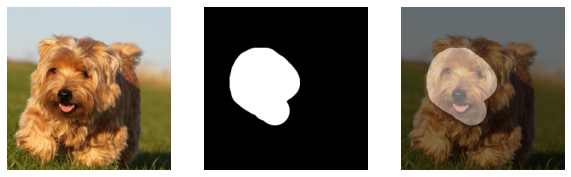

In [ ]:
assert highlight_data is not None, "Use the widget to highlight an image region"

# overlay the mask onto the user's selected image

curr_img = query_imgs[int(highlight_index)]

mask = util.durl_to_image(highlight_data)
mask_arr = np.asarray(mask)[:,:,3] / 256 # take just the alpha channel

curr_mask_overlay = util.mask_overlay(curr_img, x=0, y=0, mask_size=224, mask=mask_arr, alpha=0.5, beta=0.4)

fig = plt.figure(figsize=(10, 3))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(curr_img, cmap='gray')

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(mask_arr, cmap='gray')

plt.subplot(1,3,3)
plt.axis('off')
_ = plt.imshow(curr_mask_overlay)

## Compute activations and find similar regions
This step should take 20-40 seconds with a GPU.

In [ ]:
# input selected image into models
curr_img_tensor = query_model_transform(curr_img)
with torch.no_grad():
  late_search_tool.set_input_image(curr_img_tensor)
  early_search_tool.set_input_image(curr_img_tensor)

# assemble masks
late_transform = transforms.Resize(LATE_FEATURE_SIZE)
small_mask = late_transform(mask)
small_mask_arr = np.asarray(small_mask)[:,:,3] / 255

early_transform = transforms.Resize(EARLY_FEATURE_SIZE)
large_mask = early_transform(mask)
large_mask_arr = np.asarray(large_mask)[:,:,3] / 255

# compute the similarities
print('Loading Results...')
with torch.no_grad():
  late_sims, late_xs, late_ys = late_search_tool.compute(small_mask_arr)
  late_order = torch.argsort(late_sims, descending=True)

  early_sims, early_xs, early_ys = early_search_tool.compute(large_mask_arr)
  early_order = torch.argsort(early_sims, descending=True)
print('Done.')

Loading Results...
Done.


## Display most similar regions in activation space

Top row shows results for activations from VGG16 conv3 block (after pooling); bottom row shows results for activations from VGG16's conv5 block (after pooling).

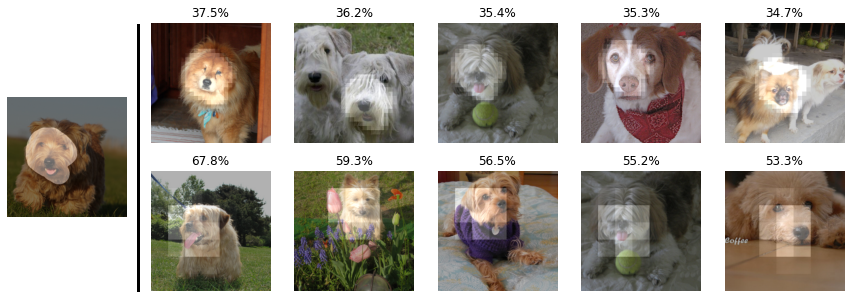

In [ ]:
# visualize results
# set up the figure
DISPLAY_NUM = 6

HEIGHT = 5
WIDTH = 15
plt.figure(figsize=(WIDTH, HEIGHT))

# show the query region on the left-hand side
ax = plt.subplot(1, DISPLAY_NUM, 1)
plt.axis('off')
plt.imshow(curr_mask_overlay)

# draw a border between query and results
ax.add_line(matplotlib.lines.Line2D([245,245], [-136,360], lw=3, color='black')).set_clip_on(False)


for i in range(DISPLAY_NUM-1):
  # handle early features
  idx = early_order[i]
  curr_img_out = util.mask_overlay(imagenet_dataset.get_vis_image(idx), 
                                   x=early_xs[idx], 
                                   y=early_ys[idx], 
                                   mask_size=EARLY_FEATURE_SIZE, 
                                   mask=util.crop_mask(large_mask_arr),
                                   alpha=0.8, beta=0.3)

  plt.subplot(2, DISPLAY_NUM, i+2)
  plt.axis('off')
  plt.imshow(curr_img_out, cmap='gray') # use cmap in case image is only 1-channel
  plt.title(str(np.round(early_sims[idx].cpu().numpy() * 100, 1)) + '%')

  # now do the same for late features
  idx = late_order[i]
  curr_img_out = util.mask_overlay(imagenet_dataset.get_vis_image(idx), 
                                   x=late_xs[idx], 
                                   y=late_ys[idx], 
                                   mask_size=LATE_FEATURE_SIZE, 
                                   mask=util.crop_mask(small_mask_arr))

  plt.subplot(2, DISPLAY_NUM, i+2 + DISPLAY_NUM)
  plt.axis('off')
  plt.imshow(curr_img_out, cmap='gray')
  plt.title(str(np.round(late_sims[idx].cpu().numpy() * 100, 1)) + '%')